In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [169]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot 
from copy import copy
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm


## Load data and do some inital EDA

In [2]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')

In [3]:
train.head(5)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
len(train)

3000888

In [9]:
unique_groups = list(train.family.unique())
print(unique_groups)
print(len(unique_groups))

['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
33


In [8]:
len(train.store_nbr.unique())

54

In [19]:
train.value_counts(subset=['family', 'store_nbr']) 

family            store_nbr
AUTOMOTIVE        1            1684
LINGERIE          51           1684
LIQUOR,WINE,BEER  8            1684
                  7            1684
                  6            1684
                               ... 
EGGS              51           1684
                  50           1684
                  49           1684
                  48           1684
SEAFOOD           54           1684
Length: 1782, dtype: int64

There are 54 unique stores and 33 product families
it appears that every single store has every single family on every single day

## Lets pivot the data to see seperate time series for each store-family combination

In [34]:
sales_pivot = train.pivot(index='date', columns=['family', 'store_nbr'], values='sales')

In [37]:
sales_pivot.head(5)

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
store_nbr,1,1,1,1,1,1,1,1,1,1,...,9,9,9,9,9,9,9,9,9,9
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,0.0,374.531,482.0,0.0,0.0,651.292,83.0,0.0,0.0,29.214
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,0.0,400.863,372.0,0.0,0.0,509.496,66.0,0.0,0.0,25.000
2013-01-04,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,...,0.0,310.878,324.0,0.0,0.0,332.672,57.0,0.0,0.0,11.000
2013-01-05,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,...,0.0,447.685,461.0,0.0,0.0,510.919,84.0,0.0,0.0,28.361


In [38]:
sales_pivot.columns

MultiIndex([(                'AUTOMOTIVE', 1),
            (                 'BABY CARE', 1),
            (                    'BEAUTY', 1),
            (                 'BEVERAGES', 1),
            (                     'BOOKS', 1),
            (              'BREAD/BAKERY', 1),
            (               'CELEBRATION', 1),
            (                  'CLEANING', 1),
            (                     'DAIRY', 1),
            (                      'DELI', 1),
            ...
            (                 'MAGAZINES', 9),
            (                     'MEATS', 9),
            (             'PERSONAL CARE', 9),
            (              'PET SUPPLIES', 9),
            (   'PLAYERS AND ELECTRONICS', 9),
            (                   'POULTRY', 9),
            (            'PREPARED FOODS', 9),
            (                   'PRODUCE', 9),
            ('SCHOOL AND OFFICE SUPPLIES', 9),
            (                   'SEAFOOD', 9)],
           names=['family', 'store_nbr'], l

## Lets start simple, lets predict LIQUOR,WINE,BEER sales in store 1

In [42]:
beer_store_1 = sales_pivot['LIQUOR,WINE,BEER', 1]
beer_store_1.head(5)

date
2013-01-01      0.0
2013-01-02     67.0
2013-01-03     66.0
2013-01-04    102.0
2013-01-05    159.0
Name: (LIQUOR,WINE,BEER, 1), dtype: float64

In [44]:
val_lenght = 15
my_train = beer_store_1[:-val_lenght]
my_val = beer_store_1[-val_lenght:]

<AxesSubplot: xlabel='date'>

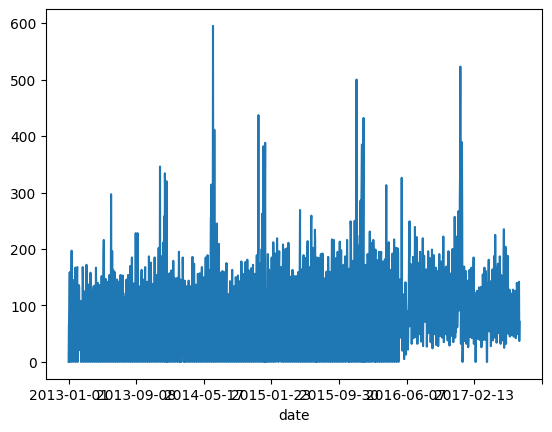

In [45]:
my_train.plot()

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


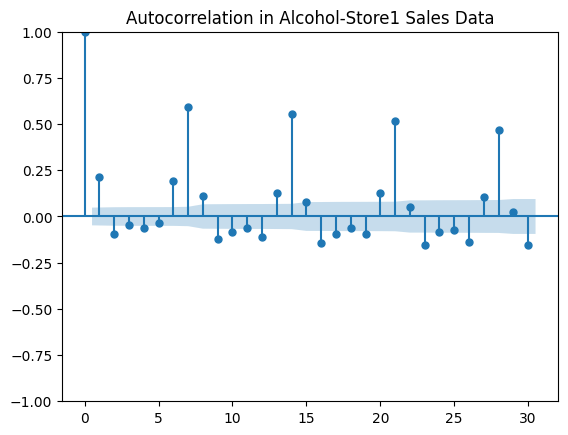

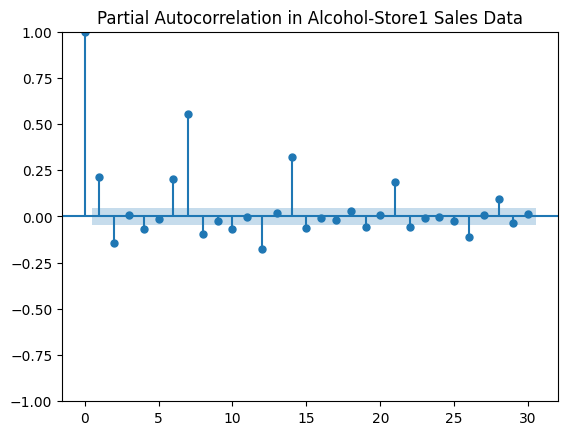

In [47]:
acf_plot = plot_acf(my_train, lags=30, title='Autocorrelation in Alcohol-Store1 Sales Data')
pacf_plot = plot_pacf(my_train, lags=30, title='Partial Autocorrelation in Alcohol-Store1 Sales Data')

In [60]:
my_train//num_chunks

date
2013-01-01     0.0
2013-01-02     6.0
2013-01-03     6.0
2013-01-04    10.0
2013-01-05    15.0
              ... 
2017-07-27     7.0
2017-07-28    13.0
2017-07-29    14.0
2017-07-30     3.0
2017-07-31     7.0
Name: (LIQUOR,WINE,BEER, 1), Length: 1669, dtype: float64

Text(0.5, 1.0, 'chunking to investigate if mean and st dev are approx constant')

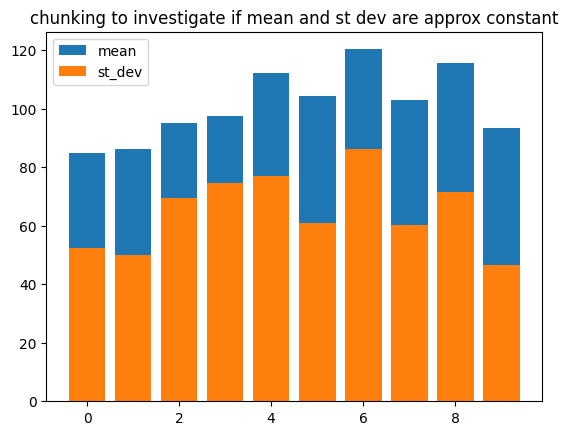

In [70]:
len_data = len(my_train)
num_chunks = 10
chunk_len = len_data//num_chunks
mean = []
st_dev = []
for i in range(num_chunks):
    data = my_train[i*chunk_len:(i+1)*chunk_len-1]
    mean.append(data.mean())
    st_dev.append(data.std())
matplotlib.pyplot.bar(range(num_chunks), mean, label='mean')
matplotlib.pyplot.bar(range(num_chunks), st_dev, label='st_dev')
matplotlib.pyplot.legend()
matplotlib.pyplot.title('chunking to investigate if mean and st dev are approx constant')



## stationary assessment

the mean and standard deviation are approximately constant
the ACF and PACF have a constant structure

hence we can say this is stationary

# Forecasting

* use mean
* use last value
* exponential smoothing
* moving avergae
* auto regression
* ARMA combined
* season decomposition forecast
* machine learning forecast

In [105]:
def compute_RMSLE(actual_val, forecast_val):
    """Root Mean Squared Logarithmic Error"""
    diff_sq = (actual_val - forecast_val)**2
    return round(diff_sq.mean()**0.5)


def plot_forecast(train, actual_val, forecast_val, model_name, title='forecast vs actual', last_n_train_days=30):
    error = compute_RMSLE(actual_val, forecast_val)
    matplotlib.pyplot.plot(train[-last_n_train_days:], label=f'last {last_n_train_days} training days')
    matplotlib.pyplot.plot(actual_val, label='actual')
    matplotlib.pyplot.plot(forecast_val, label=f'{model_name} forecast, {error} RMSLE')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.title(title)
    return None

## Predict the mean

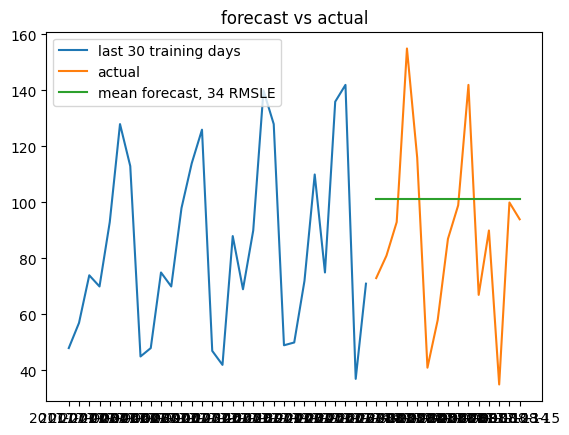

In [108]:
mean_prediction = copy(my_val)
for i in range(len(my_val)):
    mean_prediction.iloc[i] = my_train.mean()

plot_forecast(my_train, my_val, mean_prediction, 'mean', title='forecast vs actual')

## Predict the last value

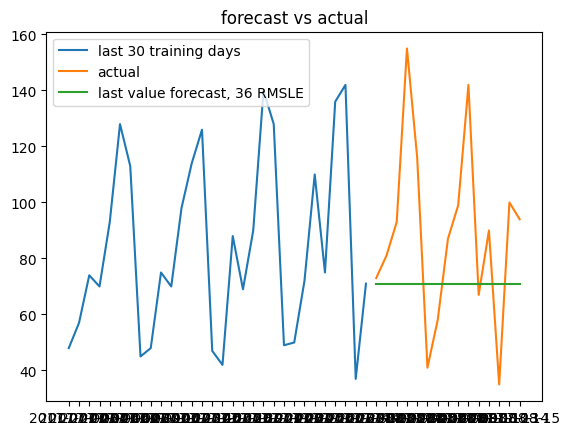

In [109]:
last_value_prediction = copy(my_val)
for i in range(len(my_val)):
    last_value_prediction.iloc[i] = my_train[-1]

plot_forecast(my_train, my_val, last_value_prediction, 'last value', title='forecast vs actual')

## Exponential Smoothing

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


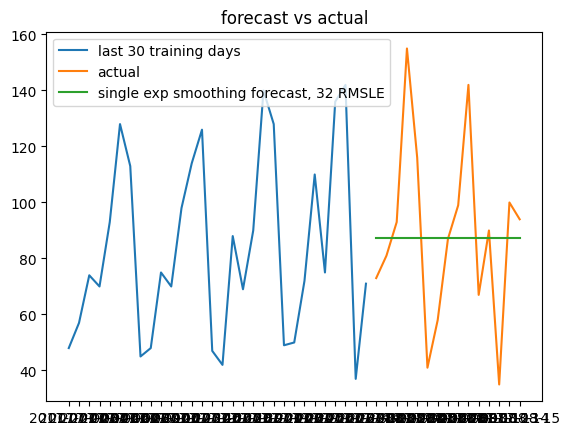

In [156]:
single = SimpleExpSmoothing(my_train).fit(optimized=True)

single_exp_preds = single.forecast(len(my_val)) # makes prediction but only outpouts value wihtout time 
first_index = single_exp_preds.first_valid_index()

single_exp_prediction = copy(my_val) 
for i in range(len(my_val)):
    single_exp_prediction.iloc[i] = single_exp_preds[first_index+i]

plot_forecast(my_train, my_val, single_exp_prediction, 'single exp smoothing', title='forecast vs actual')

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


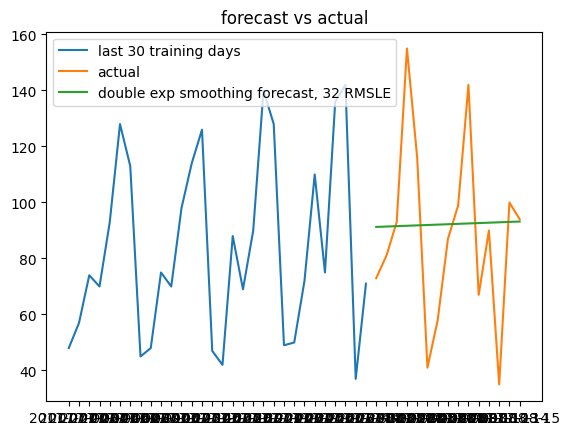

In [157]:
double = Holt(my_train).fit(optimized=True)

double_exp_preds = double.forecast(len(my_val)) # makes prediction but only outpouts value wihtout time 
first_index = double_exp_preds.first_valid_index()

double_exp_prediction = copy(my_val) 
for i in range(len(my_val)):
    double_exp_prediction.iloc[i] = double_exp_preds[first_index+i]

plot_forecast(my_train, my_val, double_exp_prediction, 'double exp smoothing', title='forecast vs actual')

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


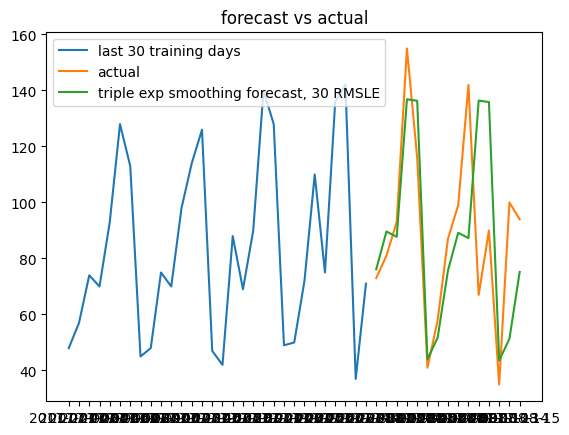

In [158]:
triple = ExponentialSmoothing(my_train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=7).fit(optimized=True)

triple_exp_preds = triple.forecast(len(my_val)) # makes prediction but only outpouts value wihtout time 
first_index = triple_exp_preds.first_valid_index()

triple_exp_prediction = copy(my_val) 
for i in range(len(my_val)):
    triple_exp_prediction.iloc[i] = triple_exp_preds[first_index+i]

plot_forecast(my_train, my_val, triple_exp_prediction, 'triple exp smoothing', title='forecast vs actual')

## ARMA models

In [171]:
dir(sm.tsa)

['AR',
 'ARDL',
 'ARIMA',
 'ArmaProcess',
 'AutoReg',
 'DynamicFactor',
 'DynamicFactorMQ',
 'ETSModel',
 'ExponentialSmoothing',
 'Holt',
 'MarkovAutoregression',
 'MarkovRegression',
 'SARIMAX',
 'STL',
 'STLForecast',
 'SVAR',
 'SimpleExpSmoothing',
 'UECM',
 'UnobservedComponents',
 'VAR',
 'VARMAX',
 'VECM',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'acf',
 'acovf',
 'add_lag',
 'add_trend',
 'adfuller',
 'ardl_select_order',
 'arima',
 'arma_generate_sample',
 'arma_order_select_ic',
 'bds',
 'bk_filter',
 'breakvar_heteroskedasticity_test',
 'ccf',
 'ccovf',
 'cf_filter',
 'coint',
 'datetools',
 'detrend',
 'filters',
 'graphics',
 'hp_filter',
 'innovations',
 'interp',
 'kpss',
 'lagmat',
 'lagmat2ds',
 'pacf',
 'pacf_ols',
 'pacf_yw',
 'q_stat',
 'range_unit_root_test',
 'seasonal_decompose',
 'statespace',
 'stattools',
 'tsatools',
 'var',
 'x13_arima_analysis',
 'x13_arima_select_order',


In [176]:
p = 1 # auto regressive part
d = 0 # number of times to difference data
q = 1 # moving average part

arma_model = sm.tsa.arima.ARIMA(my_train, order=(p, d, q))
arma_model.fit()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
